# 1. Face Detection

## 1.1 Dataset Samples

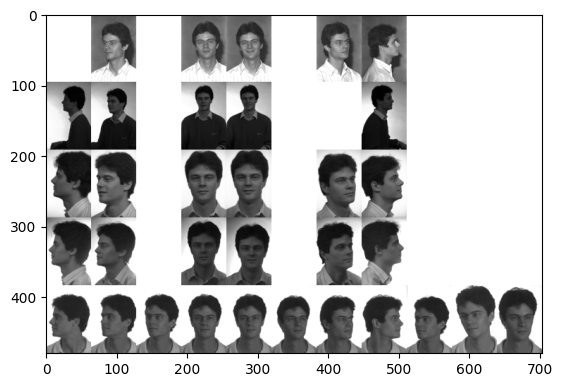

In [ ]:
import cv2
import matplotlib.pyplot as plt
montage = cv2.imread("../colorferet/colorferet/dvd2/data/montages/id/00002.ppm",0)
plt.imshow(montage, cmap='gray')

# 

## 1.2 Original image

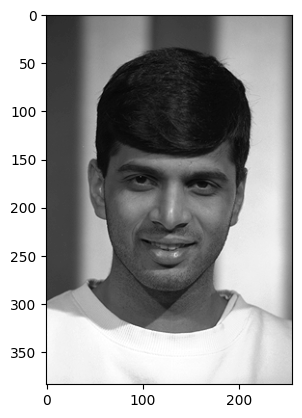

In [1]:
import matplotlib.pyplot as plt
import cv2
import dlib
image = cv2.imread("../colorferet/colorferet/dvd1/data/smaller/00188/00188_940307_fa.ppm",0)
plt.imshow(image, cmap='gray')

## 1.3 Haar Cascade Results

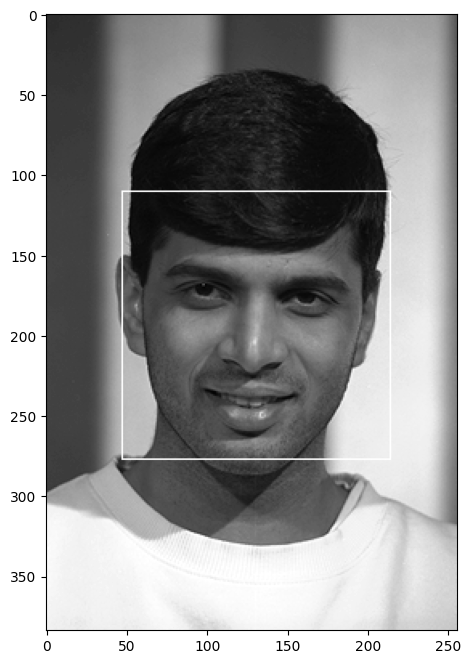

In [2]:
faceCascade = cv2.CascadeClassifier("../haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
image,
scaleFactor=1.1,
minNeighbors=5,
flags=cv2.CASCADE_SCALE_IMAGE
)
haar_img = image.copy()
for (x, y, w, h) in faces: 
    cv2.rectangle(haar_img, (x, y), (x+w, y+h), (255, 255, 255), 1)

plt.figure(figsize=(12,8))
plt.imshow(haar_img, cmap='gray')
plt.show()

## 1.4 Dlib's CNN Results

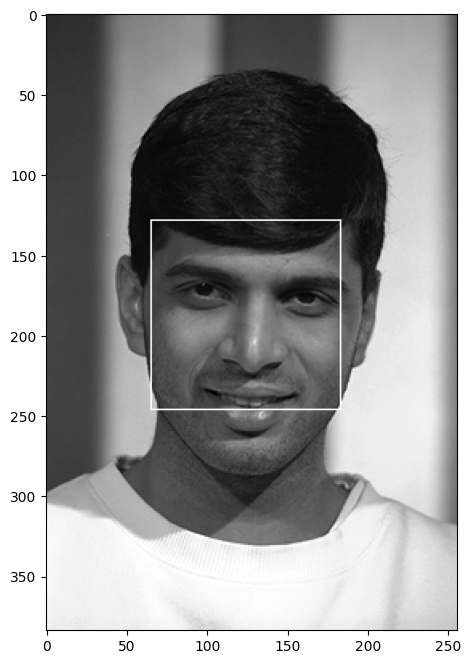

In [18]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
cnn_img = image.copy()
rects = dnnFaceDetector(cnn_img, 1)
for (i, rect) in enumerate(rects):
    x1 = rect.rect.left()
    y1 = rect.rect.top()
    x2 = rect.rect.right()
    y2 = rect.rect.bottom()
    
    cv2.rectangle(cnn_img, (x1, y1), (x2, y2), (255, 255, 255), 1)
plt.figure(figsize=(12,8))
plt.imshow(cnn_img, cmap='gray')
plt.show()

## 1.5 HoG Detection Results

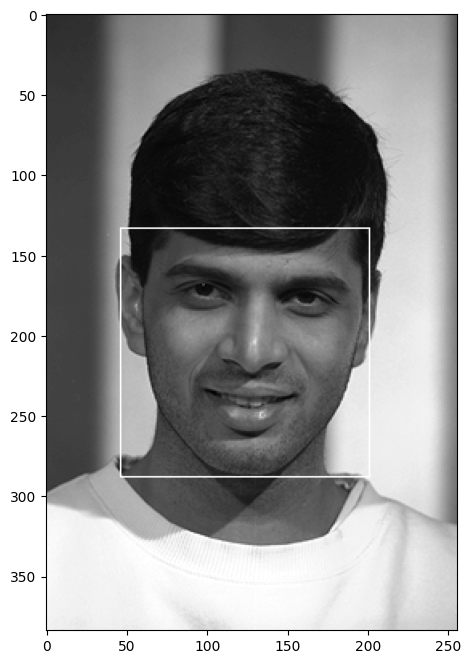

In [3]:
from imutils import face_utils
face_detect = dlib.get_frontal_face_detector()
hog_img = image.copy()
rects = face_detect(hog_img, 1)
for (i, rect) in enumerate(rects):
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(hog_img, (x, y), (x + w, y + h), (255, 255, 255), 1)
    
plt.figure(figsize=(12,8))
plt.imshow(hog_img, cmap='gray')
plt.show()

## 1.6 Functions for Used  Detection Methods

In [11]:
import dlib

def dlib_detection(image):
    dnnFaceDetector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
    rects = dnnFaceDetector(image, 1)
    cropped_face=[]
    for (i, rect) in enumerate(rects):
        x1 = rect.rect.left()
        y1 = rect.rect.top()
        x2 = rect.rect.right()
        y2 = rect.rect.bottom()
        cropped_face = image[y1:y2, x1:x2]
    return cropped_face

def haar_detection(image):
    faceCascade = cv2.CascadeClassifier("../haarcascade_frontalface_default.xml")
    cropped_face = []
    faces = faceCascade.detectMultiScale(
    image,
    scaleFactor=1.1,
    minNeighbors=5,
    flags=cv2.CASCADE_SCALE_IMAGE
    )
    for (x, y, w, h) in faces: 
        cropped_face = image[y:y+h, x:x+w]
        
    return cropped_face


# 2. Data Preparation

## 2.1 Crop Images

## 2.2 Keep subjects who have 5 or more frontal images only for the first model "recognizer-77.h5"

In [ ]:
import os
import cv2
import numpy as np
import shutil

images_arr = []
labels = []
import shutil

data_folders = ["dvd1", "dvd2"]
for folder in data_folders:
    cropped_folder = os.path.join("../colorferet/colorferet", folder, "data/haar_cropped")

    if os.path.exists(cropped_folder):
        for subject_folder in os.listdir(cropped_folder):
            subject_path = os.path.join(cropped_folder, subject_folder)
            if os.path.isdir(subject_path):
                file_count = len(os.listdir(subject_path))
                if file_count < 5:
                    print(f"Deleting folder: {subject_path}")
                    shutil.rmtree(subject_path)  
                else:
                    for image_file in os.listdir(subject_path):
                        image_path = os.path.join(subject_path, image_file)
                        if os.path.isfile(image_path):
                            image = cv2.imread(image_path, 0)
                            img = cv2.resize(image, (100, 100))
                            images_arr.append(img)
                            labels.append(subject_folder)
    else:
        print("The specified directory does not exist.")

unique_labels = np.unique(labels)
print('Number of unique labels:', len(unique_labels))


# 3. Models

## 3.1 Eigenfaces and PCA Function

In [4]:
def pca(faces,mean_face=None):
    X = np.array(faces).reshape(len(faces), -1).astype(np.float64)
    mean_face = np.mean(X, axis=0)
    X -= mean_face
    U, _, Vt = np.linalg.svd(X, full_matrices=False)
    X_pca = np.dot(X, Vt.T)
    return mean_face, Vt, X_pca

## 3.2 Grid search to find the best SVM hyperparameters

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
mean_face, eigenfaces, proj_data = pca(images_arr)
X_train, X_test, y_train, y_test = train_test_split(proj_data, labels, test_size=0.2, stratify=labels, random_state=0)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf','poly'], 'gamma': [0.1, 1, 10]}
svm_cross_valid = SVC(random_state=0)
grid_search = GridSearchCV(estimator=svm_cross_valid, param_grid=param_grid,cv=3)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best train-test split: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best train-test split:  0.7438866524587576


## 3.3 Train an SVM model with the best hyperparameters

Accuracy: 0.7518796992481203


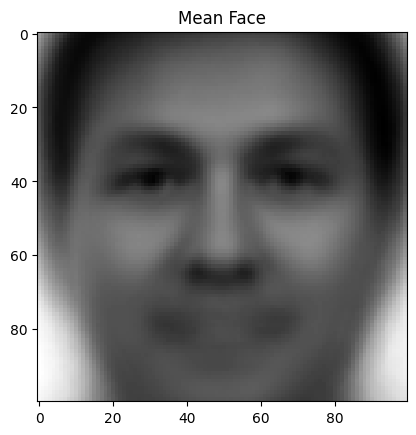

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

mean_face, eigenfaces, proj_data = pca(images_arr)
mean_face = np.reshape(mean_face, (100, 100))
plt.title("Mean Face")
plt.imshow(mean_face, cmap='gray')                                                        

X_train, X_test, y_train, y_test = train_test_split(proj_data, labels, test_size=0.25, random_state=0)

svm = SVC(kernel='linear', C=0.1,gamma=0.1, random_state=0,probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


## 3.4 Plot eigenfaces

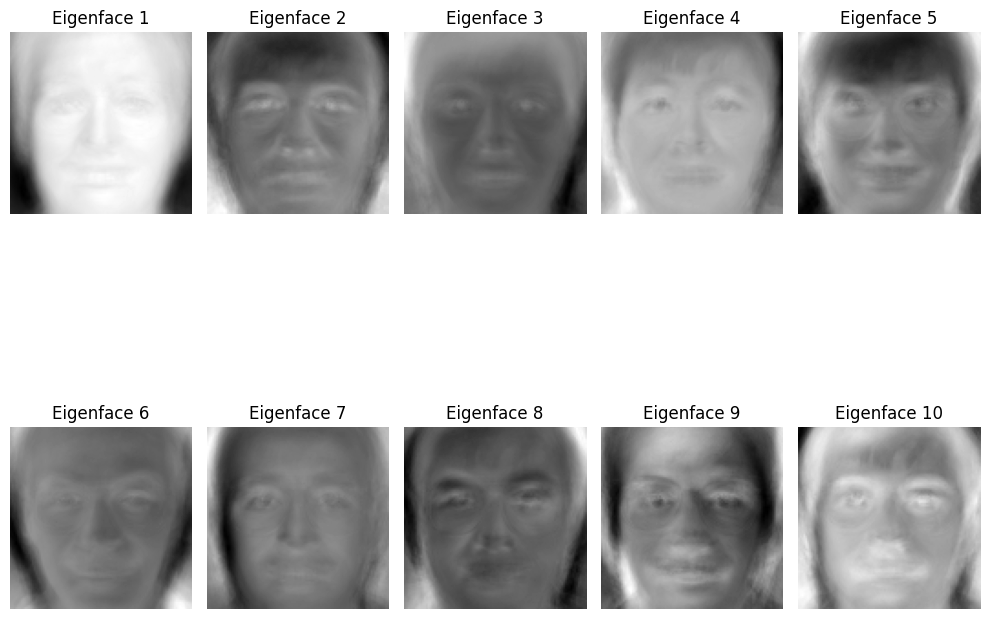

In [13]:
def plot_eigenfaces(eigenfaces, n=10, img_width=100, img_height=100):
    rows = 2
    cols = -(-n // rows) 
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10)) 
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(eigenfaces[i].reshape(img_width, img_height), cmap='gray')
            ax.set_title(f'Eigenface {i + 1}')
            ax.axis('off') 

    plt.tight_layout() 
    plt.show()

plot_eigenfaces(eigenfaces)


## 3.5 CNN model with no augmentation 

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

images = np.array(images_arr)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


X_train = X_train.reshape(-1, 100, 100, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 100, 100, 1).astype('float32') / 255.0


model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)



Epoch 1/100
20/20 [==============================] - 13s 47ms/step - loss: 3.4855 - accuracy: 0.2755 - val_loss: 4.1185 - val_accuracy: 0.0710
Epoch 2/100
20/20 [==============================] - 0s 16ms/step - loss: 1.8571 - accuracy: 0.5397 - val_loss: 4.6700 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 1.1273 - accuracy: 0.7374 - val_loss: 5.1339 - val_accuracy: 0.0194
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6422 - accuracy: 0.8671 - val_loss: 5.8034 - val_accuracy: 0.0194
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.5120 - accuracy: 0.9028 - val_loss: 6.0181 - val_accuracy: 0.0452
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 0.3047 - accuracy: 0.9611 - val_loss: 6.4669 - val_accuracy: 0.0710
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1949 - accuracy: 0.9741 - val_loss: 6.7679 - val_accuracy: 0.0710
E

## 3.6 CNN model with augmentation

In [14]:
import os
import cv2
import numpy as np
cropped_folder = "/kaggle/working/haar_cropped_all"
labels = []
images_arr = []
if os.path.exists(cropped_folder):
    for subject_folder in os.listdir(cropped_folder):
        subject_path = os.path.join(cropped_folder, subject_folder)
        if os.path.isdir(subject_path):
            file_count = len(os.listdir(subject_path))
            for image_file in os.listdir(subject_path):
                image_path = os.path.join(subject_path, image_file)
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path, 0)
                    img = cv2.resize(image, (100, 100))
                    images_arr.append(img)
                    labels.append(subject_folder)
                    if image_path.endswith(".jpg"):
                        continue
                    rotation_angle = 10 

                    rotation_matrix_left = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), rotation_angle, 1)
                    rotation_matrix_right = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), -rotation_angle, 1)
                    img_left_rotated = cv2.warpAffine(img, rotation_matrix_left, (img.shape[1], img.shape[0]))
                    img_right_rotated = cv2.warpAffine(img, rotation_matrix_right, (img.shape[1], img.shape[0]))
                    img_flipped = np.flip(img, axis=1)  
                    cv2.imwrite(os.path.join(subject_path, f"{image_file[:-4]}_left_rotated.jpg"), img_left_rotated)
                    cv2.imwrite(os.path.join(subject_path, f"{image_file[:-4]}_right_rotated.jpg"), img_right_rotated)
                    cv2.imwrite(os.path.join(subject_path, f"{image_file[:-4]}_flipped.jpg"), img_flipped)

                    images_arr.extend([img_left_rotated, img_right_rotated, img_flipped])
                    labels.extend([subject_folder, subject_folder, subject_folder])
else:
    print("The specified directory does not exist.")

unique_labels = np.unique(labels)
print('Number of images after augmentation:', len(images_arr), "for ", len(unique_labels), " subjects")


Number of images after augmentation: 11290 for  994  subjects


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

images = np.array(images_arr)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


X_train = X_train.reshape(-1, 100, 100, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 100, 100, 1).astype('float32') / 255.0


model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)



Epoch 1/100
283/283 [==============================] - 8s 18ms/step - loss: 5.9098 - accuracy: 0.0869 - val_loss: 8.1037 - val_accuracy: 0.0027
Epoch 2/100
283/283 [==============================] - 4s 15ms/step - loss: 3.5703 - accuracy: 0.3453 - val_loss: 3.3757 - val_accuracy: 0.3291
Epoch 3/100
283/283 [==============================] - 4s 15ms/step - loss: 1.6746 - accuracy: 0.7117 - val_loss: 1.5882 - val_accuracy: 0.7861
Epoch 4/100
283/283 [==============================] - 4s 15ms/step - loss: 0.6843 - accuracy: 0.8991 - val_loss: 0.4345 - val_accuracy: 0.9619
Epoch 5/100
283/283 [==============================] - 4s 15ms/step - loss: 0.3106 - accuracy: 0.9617 - val_loss: 1.6608 - val_accuracy: 0.6417
Epoch 6/100
283/283 [==============================] - 4s 15ms/step - loss: 0.1853 - accuracy: 0.9805 - val_loss: 0.2555 - val_accuracy: 0.9721
Epoch 7/100
283/283 [==============================] - 4s 15ms/step - loss: 0.1065 - accuracy: 0.9886 - val_loss: 0.0866 - val_accuracy:

In [11]:
model.save('recognition-994.h5')

In [45]:

def predict_cnn_aug(path, model, labels_list):
    img = cv2.imread(path,0)
    cropped = np.array(dlib_detection(img))
    resized = cv2.resize(cropped,(100,100))
    plt.title("Cropped Image")    
    plt.imshow(resized, cmap='gray')
    input_img = np.expand_dims(resized, axis=-1).astype('float32') / 255.0
    input_img = np.expand_dims(input_img, axis=0)
    predictions = model.predict(input_img)
    class_index = np.argmax(predictions)
    predicted_subject = labels_list[class_index]
    return predicted_subject


## Wrong output using the recognition-994.h5 model due to data imbalance

1/1 [==============================] - 0s 125ms/step
Predicted Class Using CNN:  hanya


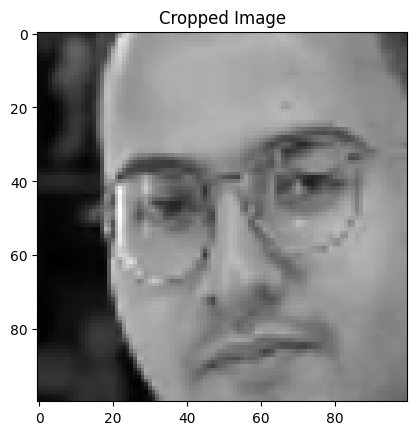

In [54]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
# Load the model from the h5 file
loaded_model = tf.keras.models.load_model('../recognition-994.h5')

# Optional: Display model summary
# print(loaded_model.summary()z)
with open("labels-994.txt", 'r') as file:
    content = file.read()
content = content.strip('[]')
elements = content.split() 
labels_list = [element.strip("'") for element in elements] 
cnn_pred_aug = predict_cnn_aug("mahmoud-test/WhatsApp Image 2023-12-26 at 12.26.32 AM.jpeg", loaded_model, labels_list=labels_list)
print ("Predicted Class Using CNN: ", cnn_pred_aug)

# 4. VGG-16 Model with Balanced Data

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

images = np.array(images_arr)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

model = tf.keras.Sequential()

# Block 1
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Output layer
model.add(tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


X_train = X_train.reshape(-1, 128, 128, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 128, 128, 1).astype('float32') / 255.0


model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)


Epoch 1/100
63/63 [==============================] - 28s 151ms/step - loss: 1.2078 - accuracy: 0.4700 - val_loss: 0.9558 - val_accuracy: 0.6340
Epoch 2/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6182 - accuracy: 0.7515 - val_loss: 0.3981 - val_accuracy: 0.8740
Epoch 3/100
63/63 [==============================] - 6s 99ms/step - loss: 0.3821 - accuracy: 0.8555 - val_loss: 0.3000 - val_accuracy: 0.8780
Epoch 4/100
63/63 [==============================] - 6s 99ms/step - loss: 0.1970 - accuracy: 0.9290 - val_loss: 0.1547 - val_accuracy: 0.9440
Epoch 5/100
63/63 [==============================] - 6s 99ms/step - loss: 0.1298 - accuracy: 0.9525 - val_loss: 0.0718 - val_accuracy: 0.9680
Epoch 6/100
63/63 [==============================] - 6s 100ms/step - loss: 0.0695 - accuracy: 0.9760 - val_loss: 0.0556 - val_accuracy: 0.9780
Epoch 7/100
63/63 [==============================] - 6s 100ms/step - loss: 0.0935 - accuracy: 0.9715 - val_loss: 0.3000 - val_accuracy: 0.9360
Ep

In [ ]:
import os
import cv2
import numpy as np
import shutil

images_arr = []
source = '/kaggle/input/haar-cropped2/haar_cropped'
destination = '/kaggle/working/haar_cropped'

# shutil.copytree(source, destination)
labels = []
cropped_folder = "/kaggle/working/haar_cropped/haar_cropped"
print("HERE", len(labels),len(images_arr))
max_images_per_class = 500

# Dictionary to track the count of images for each class
class_count = {"mahmoud": 0, "hanya": 0, "sohaila": 0, "nour": 0, "other": 0}

if os.path.exists(cropped_folder):
    for subject_folder in os.listdir(cropped_folder):
        subject_path = os.path.join(cropped_folder, subject_folder)
        if os.path.isdir(subject_path):
            file_count = len(os.listdir(subject_path))
            if file_count < 5:
                shutil.rmtree(subject_path)
                continue

            if subject_folder not in ["hanya", "mahmoud", "nour", "sohaila"]:
                if class_count["other"] < max_images_per_class:
                    for image_file in os.listdir(subject_path):
                        image_path = os.path.join(subject_path, image_file)
                        if os.path.isfile(image_path):
                            image = cv2.imread(image_path, 0)
                            img = cv2.resize(image, (128, 128))
                            images_arr.append(img)
                            labels.append("other")
                            class_count["other"] += 1
                            if class_count["other"] >= max_images_per_class:
                                break  # Stop adding images for 'other' class

            else:
                while class_count[subject_folder] < max_images_per_class:
                    for image_file in os.listdir(subject_path):
                        if class_count[subject_folder] >= max_images_per_class:
                            break  # Stop adding images for this class
                        image_path = os.path.join(subject_path, image_file)
                        if os.path.isfile(image_path):
                            image = cv2.imread(image_path, 0)
                            img = cv2.resize(image, (128, 128))
                            images_arr.append(img)
                            labels.append(subject_folder)
                            rotation_angle = 10
                            rotation_matrix_left = cv2.getRotationMatrix2D(
                                (img.shape[1] / 2, img.shape[0] / 2), rotation_angle, 1
                            )
                            rotation_matrix_right = cv2.getRotationMatrix2D(
                                (img.shape[1] / 2, img.shape[0] / 2), -rotation_angle, 1
                            )
                            img_left_rotated = cv2.warpAffine(
                                img, rotation_matrix_left, (img.shape[1], img.shape[0])
                            )
                            img_right_rotated = cv2.warpAffine(
                                img, rotation_matrix_right, (img.shape[1], img.shape[0])
                            )
                            img_flipped = np.flip(img, axis=1)  # Horizontal flip

                            # Save augmented images to the same folder
                            cv2.imwrite(
                                os.path.join(
                                    subject_path, f"{image_file[:-4]}_left_rotated.jpg"
                                ),
                                img_left_rotated,
                            )
                            cv2.imwrite(
                                os.path.join(
                                    subject_path, f"{image_file[:-4]}_right_rotated.jpg"
                                ),
                                img_right_rotated,
                            )
                            cv2.imwrite(
                                os.path.join(
                                    subject_path, f"{image_file[:-4]}_flipped.jpg"
                                ),
                                img_flipped,
                            )

                            # Append augmented images to the list and labels
                            images_arr.extend(
                                [img_left_rotated, img_right_rotated, img_flipped]
                            )
                            labels.extend(
                                [subject_folder, subject_folder, subject_folder]
                            )
                            class_count[subject_folder] += 4
else:
    print("The specified directory does not exist.")

unique_labels = np.unique(labels)
print(
    "Number of unique labels:",
    len(unique_labels),
    "Number of images",
    len(images_arr),
    class_count,
)


HERE 0 0
Number of unique labels: 5 Number of images 2500 {'mahmoud': 500, 'hanya': 500, 'sohaila': 500, 'nour': 500, 'other': 500}


In [ ]:
model.save('vgg-recognizer-aug.h5')

16/16 [==============================] - 0s 30ms/step


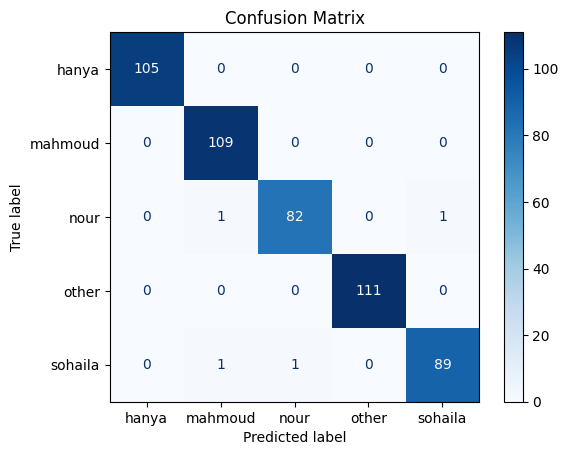

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
class_labels = ['hanya', 'mahmoud', 'nour', 'other', 'sohaila']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp = disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()